In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,recall_score,precision_score
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import KFold
import json
from joblib import dump, load
from sklearn.model_selection import cross_val_score
from mrmr import mrmr_classif
from collections import Counter
import  matplotlib.pyplot as plt


In [4]:
data = pd.read_csv('./Data/2D_t2/all.csv')
data["Label"] = data['Label'].apply(lambda x: x-1)
features = data.drop(columns=['Center','Name'])

In [5]:
spearman_corr = features.corr(method='spearman')

In [8]:
abs_corr = spearman_corr.abs()
upper_tri = abs_corr.where(~np.tril(np.ones(abs_corr.shape)).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.6)]
data_spcf = data.drop(columns=to_drop)

Apply T4: train = [AHN EMC IU MCA MCF NU], test=[NYU]

In [9]:
def get_results(acc_list,auc_list,recall_list,precision_list):    
    acc_list = np.array(acc_list)
    auc_list = np.array(auc_list)
    recall_list = np.array(recall_list)
    precision_list = np.array(precision_list)
    print(f'Recall, Average:{recall_list.mean():.4f}, Std:{recall_list.std():.4f}')
    print(f'precision, Average:{precision_list.mean():.4f}, Std:{precision_list.std():.4f}')
    print(f'Accuracy, Average:{acc_list.mean():.4f}, Std:{acc_list.std():.4f}')
    print(f'AUC, Average:{auc_list.mean():.4f}, Std:{auc_list.std():.4f}')
    return auc_list.mean()

In [13]:
train_center_data = data[data['Center'].isin(['AHN', 'EMC', 'IU', 'MCA', 'MCF', 'NU'])]
test_center_data = data[data['Center'].isin(['NYU'])]

In [10]:
train_center_data = data_spcf[data_spcf['Center'].isin(['AHN', 'EMC', 'IU', 'MCA', 'MCF', 'NU'])]
test_center_data = data_spcf[data_spcf['Center'].isin(['NYU'])]

In [155]:
X_train = train_center_data.drop(columns=['Center','Name','Label'])
y_train = train_center_data[["Label"]]


# train_data = train_center_data[selected_features]
# test_data = test_center_data[selected_features]

val_acc_list = []
val_auc_list = []
val_recall_list = []
val_precision_list = []



skf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_list = []
best_k = 0
best_auc =0
for k in range(2,50):
    for train_index, val_index in skf.split(X_train, y_train):
        train_x_raw, val_x_raw = X_train.iloc[train_index], X_train.iloc[val_index]
        train_y, val_y = y_train.iloc[train_index], y_train.iloc[val_index]

        standard_scaler = StandardScaler()
        train_x_scaled = pd.DataFrame(standard_scaler.fit_transform(train_x_raw),columns=train_x_raw.columns)
        val_x_scaled = pd.DataFrame(standard_scaler.transform(val_x_raw),columns=val_x_raw.columns)
        
        selected_features = mrmr_classif(train_x_scaled, train_y.to_numpy().squeeze(), K=k)
        # selected_features.remove('Label')
        train_x = train_x_scaled[selected_features]
        val_x = val_x_scaled[selected_features]
        # test_x = test_x_raw[selected_features]
        
        # test_x = standard_scaler.transform(test_x)

        model = RandomForestClassifier(n_estimators=51, random_state=42)
        model.fit(train_x, train_y)
    # --------------------validation----------------------
        y_pred_proba = model.predict(val_x)  # Get probabilities for the positive class
        y_pred = model.predict(val_x)

        val_accuracy = accuracy_score(val_y, y_pred)
        # print(f'Accuracy: {accuracy:.4f}')
        val_auc_score = roc_auc_score(val_y, y_pred_proba,average='micro')
        # print(f'AUC Score: {auc_score:.4f}')
        # Print the classification report
        val_recall = recall_score(val_y, y_pred)
        # print(f'Recall Score: {recall:.4f}')
        val_precision = precision_score(val_y, y_pred)
        # print(f'AUC Score: {precision:.4f}')
        val_acc_list.append(val_accuracy)
        val_auc_list.append(val_auc_score)
        val_recall_list.append(val_recall)
        val_precision_list.append(val_precision)

    # --------------------test----------------------
        # y_pred_proba = model.predict(test_x)  # Get probabilities for the positive class
        # y_pred = model.predict(test_x)

        # test_accuracy = accuracy_score(test_y, y_pred)
        # # print(f'Accuracy: {accuracy:.4f}')
        # test_auc_score = roc_auc_score(test_y, y_pred_proba)
        # # print(f'AUC Score: {auc_score:.4f}')
        # # Print the classification report
        # test_recall = recall_score(test_y, y_pred)
        # # print(f'Recall Score: {recall:.4f}')
        # test_precision = precision_score(test_y, y_pred)
        # # print(f'AUC Score: {precision:.4f}')
        # test_acc_list.append(test_accuracy)
        # test_auc_list.append(test_auc_score)
        # test_recall_list.append(test_recall)
        # test_precision_list.append(test_precision)
        # Save the model
        # dump(model, f'./RFmodels_3d/RF_{fold}.joblib')

    print('Validation set')
    auc = get_results(val_acc_list,val_auc_list,val_recall_list,val_precision_list)
    auc_list.append(auc)
    if auc>=best_auc:
        best_k=k
        best_auc=auc
    print('--------------------')
    # print("Test set")
    # get_results(test_acc_list,test_auc_list,test_recall_list,test_precision_list)
    # print('================================================')
print(best_k)

100%|██████████| 2/2 [00:00<00:00, 41.20it/s]


Validation set
Recall, Average:0.4249, Std:0.1033
precision, Average:0.4968, Std:0.1361
Accuracy, Average:0.5685, Std:0.0828
AUC, Average:0.5536, Std:0.0764
--------------------


100%|██████████| 3/3 [00:00<00:00, 40.73it/s]


Validation set
Recall, Average:0.4338, Std:0.0888
precision, Average:0.5107, Std:0.1229
Accuracy, Average:0.5822, Std:0.0626
AUC, Average:0.5653, Std:0.0591
--------------------


100%|██████████| 4/4 [00:00<00:00, 37.30it/s]


Validation set
Recall, Average:0.4366, Std:0.0811
precision, Average:0.5075, Std:0.1095
Accuracy, Average:0.5798, Std:0.0619
AUC, Average:0.5631, Std:0.0554
--------------------


100%|██████████| 5/5 [00:00<00:00, 33.29it/s]


Validation set
Recall, Average:0.4557, Std:0.0893
precision, Average:0.5172, Std:0.1216
Accuracy, Average:0.5875, Std:0.0711
AUC, Average:0.5715, Std:0.0669
--------------------


100%|██████████| 6/6 [00:00<00:00, 25.84it/s]


Validation set
Recall, Average:0.4607, Std:0.0906
precision, Average:0.5207, Std:0.1259
Accuracy, Average:0.5914, Std:0.0753
AUC, Average:0.5745, Std:0.0725
--------------------


100%|██████████| 7/7 [00:00<00:00, 29.61it/s]


Validation set
Recall, Average:0.4660, Std:0.0899
precision, Average:0.5273, Std:0.1347
Accuracy, Average:0.5957, Std:0.0782
AUC, Average:0.5790, Std:0.0768
--------------------


100%|██████████| 8/8 [00:00<00:00, 27.15it/s]


Validation set
Recall, Average:0.4719, Std:0.0948
precision, Average:0.5350, Std:0.1452
Accuracy, Average:0.6013, Std:0.0837
AUC, Average:0.5841, Std:0.0832
--------------------


100%|██████████| 9/9 [00:00<00:00, 30.41it/s]


Validation set
Recall, Average:0.4737, Std:0.1012
precision, Average:0.5423, Std:0.1574
Accuracy, Average:0.6064, Std:0.0883
AUC, Average:0.5884, Std:0.0900
--------------------


100%|██████████| 10/10 [00:00<00:00, 32.00it/s]


Validation set
Recall, Average:0.4749, Std:0.1048
precision, Average:0.5429, Std:0.1592
Accuracy, Average:0.6083, Std:0.0872
AUC, Average:0.5896, Std:0.0906
--------------------


100%|██████████| 11/11 [00:00<00:00, 30.67it/s]


Validation set
Recall, Average:0.4736, Std:0.1014
precision, Average:0.5488, Std:0.1607
Accuracy, Average:0.6117, Std:0.0863
AUC, Average:0.5923, Std:0.0895
--------------------


100%|██████████| 12/12 [00:00<00:00, 29.92it/s]


Validation set
Recall, Average:0.4684, Std:0.1002
precision, Average:0.5503, Std:0.1613
Accuracy, Average:0.6119, Std:0.0859
AUC, Average:0.5919, Std:0.0885
--------------------


100%|██████████| 13/13 [00:00<00:00, 30.93it/s]


Validation set
Recall, Average:0.4641, Std:0.1027
precision, Average:0.5492, Std:0.1613
Accuracy, Average:0.6109, Std:0.0858
AUC, Average:0.5906, Std:0.0887
--------------------


100%|██████████| 14/14 [00:00<00:00, 28.09it/s]


Validation set
Recall, Average:0.4669, Std:0.1023
precision, Average:0.5559, Std:0.1641
Accuracy, Average:0.6149, Std:0.0863
AUC, Average:0.5944, Std:0.0892
--------------------


100%|██████████| 15/15 [00:00<00:00, 30.86it/s]


Validation set
Recall, Average:0.4685, Std:0.1016
precision, Average:0.5593, Std:0.1654
Accuracy, Average:0.6170, Std:0.0863
AUC, Average:0.5964, Std:0.0893
--------------------


100%|██████████| 16/16 [00:00<00:00, 28.96it/s]


Validation set
Recall, Average:0.4691, Std:0.1023
precision, Average:0.5633, Std:0.1682
Accuracy, Average:0.6198, Std:0.0866
AUC, Average:0.5987, Std:0.0902
--------------------


100%|██████████| 17/17 [00:00<00:00, 29.57it/s]


Validation set
Recall, Average:0.4681, Std:0.1010
precision, Average:0.5652, Std:0.1689
Accuracy, Average:0.6203, Std:0.0863
AUC, Average:0.5991, Std:0.0899
--------------------


100%|██████████| 18/18 [00:00<00:00, 28.61it/s]


Validation set
Recall, Average:0.4674, Std:0.1030
precision, Average:0.5662, Std:0.1705
Accuracy, Average:0.6212, Std:0.0866
AUC, Average:0.5997, Std:0.0909
--------------------


100%|██████████| 19/19 [00:00<00:00, 29.56it/s]


Validation set
Recall, Average:0.4687, Std:0.1020
precision, Average:0.5674, Std:0.1702
Accuracy, Average:0.6221, Std:0.0860
AUC, Average:0.6007, Std:0.0905
--------------------


100%|██████████| 20/20 [00:00<00:00, 29.68it/s]


Validation set
Recall, Average:0.4698, Std:0.1011
precision, Average:0.5685, Std:0.1711
Accuracy, Average:0.6228, Std:0.0861
AUC, Average:0.6015, Std:0.0907
--------------------


100%|██████████| 21/21 [00:00<00:00, 30.75it/s]


Validation set
Recall, Average:0.4703, Std:0.1008
precision, Average:0.5709, Std:0.1734
Accuracy, Average:0.6240, Std:0.0865
AUC, Average:0.6026, Std:0.0911
--------------------


100%|██████████| 22/22 [00:00<00:00, 28.24it/s]


Validation set
Recall, Average:0.4714, Std:0.1013
precision, Average:0.5727, Std:0.1746
Accuracy, Average:0.6250, Std:0.0869
AUC, Average:0.6037, Std:0.0917
--------------------


100%|██████████| 23/23 [00:00<00:00, 31.25it/s]


Validation set
Recall, Average:0.4727, Std:0.1013
precision, Average:0.5745, Std:0.1755
Accuracy, Average:0.6263, Std:0.0873
AUC, Average:0.6050, Std:0.0923
--------------------


100%|██████████| 24/24 [00:00<00:00, 29.35it/s]


Validation set
Recall, Average:0.4732, Std:0.1003
precision, Average:0.5764, Std:0.1756
Accuracy, Average:0.6275, Std:0.0867
AUC, Average:0.6062, Std:0.0918
--------------------


100%|██████████| 25/25 [00:00<00:00, 28.73it/s]


Validation set
Recall, Average:0.4724, Std:0.1000
precision, Average:0.5773, Std:0.1768
Accuracy, Average:0.6280, Std:0.0864
AUC, Average:0.6064, Std:0.0919
--------------------


100%|██████████| 26/26 [00:00<00:00, 29.30it/s]


Validation set
Recall, Average:0.4720, Std:0.1002
precision, Average:0.5784, Std:0.1772
Accuracy, Average:0.6284, Std:0.0867
AUC, Average:0.6069, Std:0.0922
--------------------


100%|██████████| 27/27 [00:01<00:00, 25.39it/s]


Validation set
Recall, Average:0.4718, Std:0.1004
precision, Average:0.5783, Std:0.1767
Accuracy, Average:0.6286, Std:0.0860
AUC, Average:0.6070, Std:0.0917
--------------------


100%|██████████| 28/28 [00:00<00:00, 29.98it/s]


Validation set
Recall, Average:0.4731, Std:0.1011
precision, Average:0.5814, Std:0.1774
Accuracy, Average:0.6309, Std:0.0859
AUC, Average:0.6091, Std:0.0920
--------------------


100%|██████████| 29/29 [00:00<00:00, 30.51it/s]


Validation set
Recall, Average:0.4724, Std:0.0999
precision, Average:0.5812, Std:0.1760
Accuracy, Average:0.6310, Std:0.0846
AUC, Average:0.6091, Std:0.0907
--------------------


100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Validation set
Recall, Average:0.4720, Std:0.0995
precision, Average:0.5813, Std:0.1765
Accuracy, Average:0.6312, Std:0.0841
AUC, Average:0.6091, Std:0.0905
--------------------


100%|██████████| 31/31 [00:01<00:00, 29.52it/s]


Validation set
Recall, Average:0.4712, Std:0.0993
precision, Average:0.5822, Std:0.1765
Accuracy, Average:0.6316, Std:0.0834
AUC, Average:0.6093, Std:0.0899
--------------------


100%|██████████| 32/32 [00:01<00:00, 29.49it/s]


Validation set
Recall, Average:0.4704, Std:0.0989
precision, Average:0.5839, Std:0.1766
Accuracy, Average:0.6324, Std:0.0831
AUC, Average:0.6099, Std:0.0895
--------------------


100%|██████████| 33/33 [00:01<00:00, 30.27it/s]


Validation set
Recall, Average:0.4694, Std:0.0978
precision, Average:0.5850, Std:0.1761
Accuracy, Average:0.6329, Std:0.0823
AUC, Average:0.6102, Std:0.0886
--------------------


100%|██████████| 34/34 [00:01<00:00, 30.89it/s]


Validation set
Recall, Average:0.4680, Std:0.0983
precision, Average:0.5850, Std:0.1761
Accuracy, Average:0.6330, Std:0.0815
AUC, Average:0.6100, Std:0.0882
--------------------


100%|██████████| 35/35 [00:01<00:00, 28.63it/s]


Validation set
Recall, Average:0.4684, Std:0.0981
precision, Average:0.5861, Std:0.1762
Accuracy, Average:0.6337, Std:0.0807
AUC, Average:0.6106, Std:0.0876
--------------------


100%|██████████| 36/36 [00:01<00:00, 19.00it/s]


Validation set
Recall, Average:0.4680, Std:0.0974
precision, Average:0.5872, Std:0.1764
Accuracy, Average:0.6341, Std:0.0804
AUC, Average:0.6109, Std:0.0871
--------------------


100%|██████████| 37/37 [00:01<00:00, 30.30it/s]


Validation set
Recall, Average:0.4673, Std:0.0967
precision, Average:0.5878, Std:0.1764
Accuracy, Average:0.6342, Std:0.0802
AUC, Average:0.6110, Std:0.0869
--------------------


100%|██████████| 38/38 [00:01<00:00, 30.43it/s]


Validation set
Recall, Average:0.4668, Std:0.0966
precision, Average:0.5886, Std:0.1764
Accuracy, Average:0.6345, Std:0.0801
AUC, Average:0.6113, Std:0.0868
--------------------


100%|██████████| 39/39 [00:01<00:00, 29.71it/s]


Validation set
Recall, Average:0.4665, Std:0.0960
precision, Average:0.5896, Std:0.1762
Accuracy, Average:0.6352, Std:0.0795
AUC, Average:0.6118, Std:0.0863
--------------------


100%|██████████| 40/40 [00:01<00:00, 30.66it/s]


Validation set
Recall, Average:0.4668, Std:0.0961
precision, Average:0.5903, Std:0.1761
Accuracy, Average:0.6357, Std:0.0792
AUC, Average:0.6123, Std:0.0861
--------------------


100%|██████████| 41/41 [00:01<00:00, 30.04it/s]


Validation set
Recall, Average:0.4656, Std:0.0961
precision, Average:0.5910, Std:0.1765
Accuracy, Average:0.6358, Std:0.0791
AUC, Average:0.6123, Std:0.0861
--------------------


100%|██████████| 42/42 [00:01<00:00, 28.33it/s]


Validation set
Recall, Average:0.4653, Std:0.0958
precision, Average:0.5922, Std:0.1768
Accuracy, Average:0.6364, Std:0.0791
AUC, Average:0.6128, Std:0.0860
--------------------


100%|██████████| 43/43 [00:01<00:00, 29.03it/s]


Validation set
Recall, Average:0.4651, Std:0.0956
precision, Average:0.5929, Std:0.1770
Accuracy, Average:0.6369, Std:0.0787
AUC, Average:0.6131, Std:0.0858
--------------------


100%|██████████| 44/44 [00:01<00:00, 29.45it/s]


Validation set
Recall, Average:0.4640, Std:0.0958
precision, Average:0.5930, Std:0.1769
Accuracy, Average:0.6368, Std:0.0783
AUC, Average:0.6130, Std:0.0856
--------------------


100%|██████████| 45/45 [00:01<00:00, 29.85it/s]


Validation set
Recall, Average:0.4637, Std:0.0962
precision, Average:0.5938, Std:0.1778
Accuracy, Average:0.6372, Std:0.0784
AUC, Average:0.6133, Std:0.0859
--------------------


100%|██████████| 46/46 [00:01<00:00, 25.42it/s]


Validation set
Recall, Average:0.4638, Std:0.0970
precision, Average:0.5944, Std:0.1778
Accuracy, Average:0.6378, Std:0.0782
AUC, Average:0.6138, Std:0.0859
--------------------


100%|██████████| 47/47 [00:01<00:00, 26.35it/s]


Validation set
Recall, Average:0.4641, Std:0.0966
precision, Average:0.5948, Std:0.1779
Accuracy, Average:0.6380, Std:0.0783
AUC, Average:0.6140, Std:0.0860
--------------------


100%|██████████| 48/48 [00:01<00:00, 29.76it/s]


Validation set
Recall, Average:0.4649, Std:0.0964
precision, Average:0.5957, Std:0.1774
Accuracy, Average:0.6386, Std:0.0781
AUC, Average:0.6147, Std:0.0858
--------------------


100%|██████████| 49/49 [00:01<00:00, 30.25it/s]


Validation set
Recall, Average:0.4636, Std:0.0962
precision, Average:0.5961, Std:0.1777
Accuracy, Average:0.6385, Std:0.0778
AUC, Average:0.6145, Std:0.0856
--------------------
48


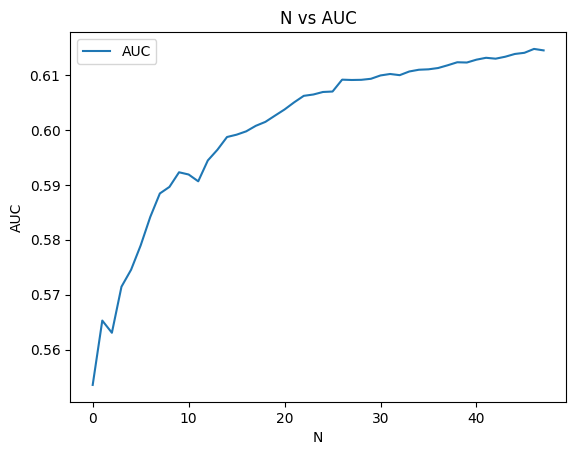

In [157]:
plt.plot(range(48),auc_list, label='AUC')
plt.title('N vs AUC')
plt.xlabel('N')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [161]:
X_train = train_center_data.drop(columns=['Center','Name','Label'])
y_train = train_center_data[["Label"]]

val_acc_list = []
val_auc_list = []
val_recall_list = []
val_precision_list = []


skf = KFold(n_splits=5, shuffle=True, random_state=1)
features_count_list = []
best_k = 0
best_auc =0
for i in range(50):
    print(f'Iteration:{i+1}')
    for train_index, val_index in skf.split(X_train, y_train):
        train_x_raw, val_x_raw = X_train.iloc[train_index], X_train.iloc[val_index]
        train_y, val_y = y_train.iloc[train_index], y_train.iloc[val_index]

        standard_scaler = StandardScaler()
        train_x_scaled = pd.DataFrame(standard_scaler.fit_transform(train_x_raw),columns=train_x_raw.columns)
        val_x_scaled = pd.DataFrame(standard_scaler.transform(val_x_raw),columns=val_x_raw.columns)
        
        selected_features = mrmr_classif(train_x_scaled, train_y.to_numpy().squeeze(), K=30)
        features_count_list+=selected_features
        # selected_features.remove('Label')
        train_x = train_x_scaled[selected_features]
        val_x = val_x_scaled[selected_features]
        # test_x = test_x_raw[selected_features]
        
        # test_x = standard_scaler.transform(test_x)

        model = RandomForestClassifier(n_estimators=51, random_state=42)
        model.fit(train_x, train_y)
    # --------------------validation----------------------
        y_pred_proba = model.predict(val_x)  # Get probabilities for the positive class
        y_pred = model.predict(val_x)

        val_accuracy = accuracy_score(val_y, y_pred)
        # print(f'Accuracy: {accuracy:.4f}')
        val_auc_score = roc_auc_score(val_y, y_pred_proba,average='micro')
        # print(f'AUC Score: {auc_score:.4f}')
        val_recall = recall_score(val_y, y_pred)
        # print(f'Recall Score: {recall:.4f}')
        val_precision = precision_score(val_y, y_pred)
        # print(f'AUC Score: {precision:.4f}')
        val_acc_list.append(val_accuracy)
        val_auc_list.append(val_auc_score)
        val_recall_list.append(val_recall)
        val_precision_list.append(val_precision)

    # --------------------test----------------------
        # y_pred_proba = model.predict(test_x)  # Get probabilities for the positive class
        # y_pred = model.predict(test_x)

        # test_accuracy = accuracy_score(test_y, y_pred)
        # # print(f'Accuracy: {accuracy:.4f}')
        # test_auc_score = roc_auc_score(test_y, y_pred_proba)
        # # print(f'AUC Score: {auc_score:.4f}')
        # # Print the classification report
        # test_recall = recall_score(test_y, y_pred)
        # # print(f'Recall Score: {recall:.4f}')
        # test_precision = precision_score(test_y, y_pred)
        # # print(f'AUC Score: {precision:.4f}')
        # test_acc_list.append(test_accuracy)
        # test_auc_list.append(test_auc_score)
        # test_recall_list.append(test_recall)
        # test_precision_list.append(test_precision)
        # Save the model
        # dump(model, f'./RFmodels_3d/RF_{fold}.joblib')

print('Validation set')

# print("Test set")
# get_results(test_acc_list,test_auc_list,test_recall_list,test_precision_list)
# print('================================================')


Iteration:1


100%|██████████| 30/30 [00:01<00:00, 28.45it/s]


Iteration:2


100%|██████████| 30/30 [00:00<00:00, 34.66it/s]


Iteration:3


100%|██████████| 30/30 [00:01<00:00, 28.64it/s]


Iteration:4


100%|██████████| 30/30 [00:00<00:00, 31.67it/s]


Iteration:5


100%|██████████| 30/30 [00:00<00:00, 32.35it/s]


Iteration:6


100%|██████████| 30/30 [00:00<00:00, 34.98it/s]


Iteration:7


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


Iteration:8


100%|██████████| 30/30 [00:00<00:00, 34.40it/s]


Iteration:9


100%|██████████| 30/30 [00:00<00:00, 33.17it/s]


Iteration:10


100%|██████████| 30/30 [00:00<00:00, 35.99it/s]


Iteration:11


100%|██████████| 30/30 [00:00<00:00, 35.18it/s]


Iteration:12


100%|██████████| 30/30 [00:00<00:00, 35.08it/s]


Iteration:13


100%|██████████| 30/30 [00:01<00:00, 22.58it/s]


Iteration:14


100%|██████████| 30/30 [00:01<00:00, 26.84it/s]


Iteration:15


100%|██████████| 30/30 [00:01<00:00, 29.99it/s]


Iteration:16


100%|██████████| 30/30 [00:01<00:00, 29.31it/s]


Iteration:17


100%|██████████| 30/30 [00:01<00:00, 25.45it/s]


Iteration:18


100%|██████████| 30/30 [00:01<00:00, 25.25it/s]


Iteration:19


100%|██████████| 30/30 [00:01<00:00, 24.33it/s]


Iteration:20


100%|██████████| 30/30 [00:01<00:00, 29.08it/s]


Iteration:21


100%|██████████| 30/30 [00:01<00:00, 28.43it/s]


Iteration:22


100%|██████████| 30/30 [00:01<00:00, 29.08it/s]


Iteration:23


100%|██████████| 30/30 [00:01<00:00, 29.35it/s]


Iteration:24


100%|██████████| 30/30 [00:01<00:00, 29.68it/s]


Iteration:25


100%|██████████| 30/30 [00:00<00:00, 31.70it/s]


Iteration:26


100%|██████████| 30/30 [00:01<00:00, 29.10it/s]


Iteration:27


100%|██████████| 30/30 [00:00<00:00, 30.06it/s]


Iteration:28


100%|██████████| 30/30 [00:01<00:00, 29.87it/s]


Iteration:29


100%|██████████| 30/30 [00:01<00:00, 29.21it/s]


Iteration:30


100%|██████████| 30/30 [00:00<00:00, 30.16it/s]


Iteration:31


100%|██████████| 30/30 [00:01<00:00, 29.05it/s]


Iteration:32


100%|██████████| 30/30 [00:01<00:00, 29.82it/s]


Iteration:33


100%|██████████| 30/30 [00:01<00:00, 29.94it/s]


Iteration:34


100%|██████████| 30/30 [00:01<00:00, 29.43it/s]


Iteration:35


100%|██████████| 30/30 [00:01<00:00, 27.17it/s]


Iteration:36


100%|██████████| 30/30 [00:01<00:00, 29.15it/s]


Iteration:37


100%|██████████| 30/30 [00:01<00:00, 29.78it/s]


Iteration:38


100%|██████████| 30/30 [00:01<00:00, 29.02it/s]


Iteration:39


100%|██████████| 30/30 [00:01<00:00, 28.33it/s]


Iteration:40


100%|██████████| 30/30 [00:01<00:00, 28.70it/s]


Iteration:41


100%|██████████| 30/30 [00:01<00:00, 28.32it/s]


Iteration:42


100%|██████████| 30/30 [00:01<00:00, 26.77it/s]


Iteration:43


100%|██████████| 30/30 [00:01<00:00, 29.48it/s]


Iteration:44


100%|██████████| 30/30 [00:01<00:00, 26.07it/s]


Iteration:45


100%|██████████| 30/30 [00:00<00:00, 30.03it/s]


Iteration:46


100%|██████████| 30/30 [00:01<00:00, 29.21it/s]


Iteration:47


100%|██████████| 30/30 [00:01<00:00, 25.19it/s]


Iteration:48


100%|██████████| 30/30 [00:01<00:00, 29.17it/s]


Iteration:49


100%|██████████| 30/30 [00:01<00:00, 29.36it/s]


Iteration:50


100%|██████████| 30/30 [00:01<00:00, 29.69it/s]


Validation set


In [170]:
feature_list = []
for key, value in Counter(features_count_list).items():
    if value/250>=0.7:
        feature_list.append(key)

In [21]:
# feature_list.sort()
Maria_list = [
'skewness-Gradient diagonal',
'skewness-Laws S3S3',
'skewness-Laws E5W5',
'Collage_kurt_Correlation_1_nb_8_ws_3',
'Collage_skew_InformationMeasureOfCorrelation1_1_nb_8_ws_3',
'Collage_kurt_InformationMeasureOfCorrelation2_1_nb_8_ws_3',
'Collage_kurt_InformationMeasureOfCorrelation2_1_nb_16_ws_3',
'Collage_kurt_AngularSecondMoment_1_nb_4_ws_5',
'Collage_kurt_InformationMeasureOfCorrelation2_1_nb_32_ws_5',
'skewness-Haralick correlation ws=3 n=4',
'kurtosis-Haralick inertia ws=3 n=16'
]

In [23]:
X_train = train_center_data.drop(columns=['Center','Name','Label'])
y_train = train_center_data[["Label"]]

test_x_raw = test_center_data.drop(columns=['Center','Name','Label'])
test_y = test_center_data[["Label"]]

test_acc_list = []
test_auc_list = []
test_recall_list = []
test_precision_list = []

skf = KFold(n_splits=5, shuffle=True, random_state=1)
features_count_list = []
best_k = 0
best_auc =0

for train_index, val_index in skf.split(X_train, y_train):
    train_x_raw, val_x_raw = X_train.iloc[train_index], X_train.iloc[val_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[val_index]

    standard_scaler = StandardScaler()
    train_x_scaled = pd.DataFrame(standard_scaler.fit_transform(train_x_raw),columns=train_x_raw.columns)
    val_x_scaled = pd.DataFrame(standard_scaler.transform(val_x_raw),columns=val_x_raw.columns)
    test_x_scaled = pd.DataFrame(standard_scaler.transform(test_x_raw),columns=test_x_raw.columns)

    train_x = train_x_scaled[Maria_list]
    val_x = val_x_scaled[Maria_list]
    test_x = test_x_scaled[Maria_list]

    model = RandomForestClassifier(n_estimators=51, random_state=42)
    model.fit(train_x, train_y)
# --------------------validation----------------------
    # y_pred_proba = model.predict(val_x)  # Get probabilities for the positive class
    # y_pred = model.predict(val_x)

    # val_accuracy = accuracy_score(val_y, y_pred)
    # # print(f'Accuracy: {accuracy:.4f}')
    # val_auc_score = roc_auc_score(val_y, y_pred_proba,average='micro')
    # # print(f'AUC Score: {auc_score:.4f}')
    # val_recall = recall_score(val_y, y_pred)
    # # print(f'Recall Score: {recall:.4f}')
    # val_precision = precision_score(val_y, y_pred)
    # # print(f'AUC Score: {precision:.4f}')
    # val_acc_list.append(val_accuracy)
    # val_auc_list.append(val_auc_score)
    # val_recall_list.append(val_recall)
    # val_precision_list.append(val_precision)

# --------------------test----------------------
    y_pred_proba = model.predict(test_x)  # Get probabilities for the positive class
    y_pred = model.predict(test_x)

    test_accuracy = accuracy_score(test_y, y_pred)
    # print(f'Accuracy: {accuracy:.4f}')
    test_auc_score = roc_auc_score(test_y, y_pred_proba)
    # print(f'AUC Score: {auc_score:.4f}')
    # Print the classification report
    test_recall = recall_score(test_y, y_pred)
    # print(f'Recall Score: {recall:.4f}')
    test_precision = precision_score(test_y, y_pred)
    # print(f'AUC Score: {precision:.4f}')
    test_acc_list.append(test_accuracy)
    test_auc_list.append(test_auc_score)
    test_recall_list.append(test_recall)
    test_precision_list.append(test_precision)
    # Save the model
    # dump(model, f'./RFmodels_3d/RF_{fold}.joblib')

print("Test set")
get_results(test_acc_list,test_auc_list,test_recall_list,test_precision_list)
print('================================================')


Test set
Recall, Average:0.5818, Std:0.0530
precision, Average:0.4749, Std:0.0182
Accuracy, Average:0.6704, Std:0.0144
AUC, Average:0.6460, Std:0.0158
